In [1]:
# Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
#Model
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
#Model Analysis
from sklearn.metrics import confusion_matrix

In [84]:
path='../input/covid19data'

diagnosis_code_dict={
    'COVID':0,
    'Normal':1,
    'Viral Pneumonia':2
}

diagnosis_label_dict={
    'COVID':'Covid-19',
    'Normal':'Halthy Lungs',
    'Viral Pneumonia':'Viral Pneumonia'
}

image_path_dict={os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join(path,'*','*.png'))}

covidData=pd.DataFrame.from_dict(image_path_dict,orient='index').reset_index()

covidData.columns=['image_id','path']
classes=covidData.image_id.str.split('-').str[0]
covidData['diagnosis']=classes
covidData['target']=covidData['diagnosis'].map(diagnosis_code_dict.get)
covidData['Class']=covidData['diagnosis'].map(diagnosis_label_dict.get)

In [85]:
samples,features=covidData.shape
duplicate=covidData.duplicated().sum()
null_val=covidData.isnull().sum()

print(samples)
print(features)
print(duplicate)
print(null_val)

15153
5
0
image_id     0
path         0
diagnosis    0
target       0
Class        0
dtype: int64


In [ ]:
covidData

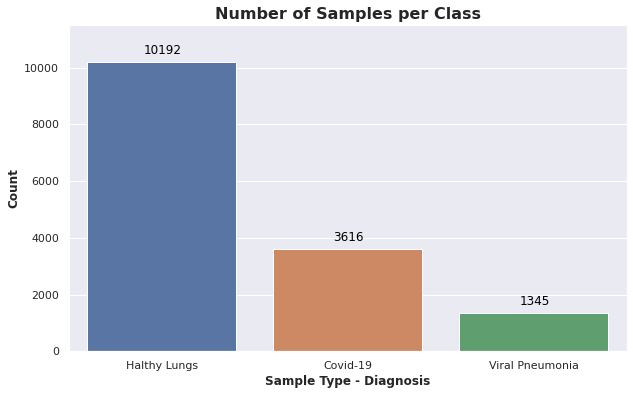

In [86]:
from decimal import Decimal
plt.figure(figsize=(10,6))
ax=sns.countplot(data=covidData,x='Class',order=covidData['Class'].value_counts().index)
for p in ax.patches:
    ax.annotate('{}'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()),ha='center', va='bottom', color='black', xytext=(75,5),rotation = 'horizontal',
    textcoords='offset points')
plt.ylim(0,11500)
plt.title('Number of Samples per Class',fontsize=16,weight='bold')
ax.set_xlabel('Sample Type - Diagnosis',weight='bold')
ax.set_ylabel('Count',weight='bold')
plt.savefig('bar chart distribution.png')

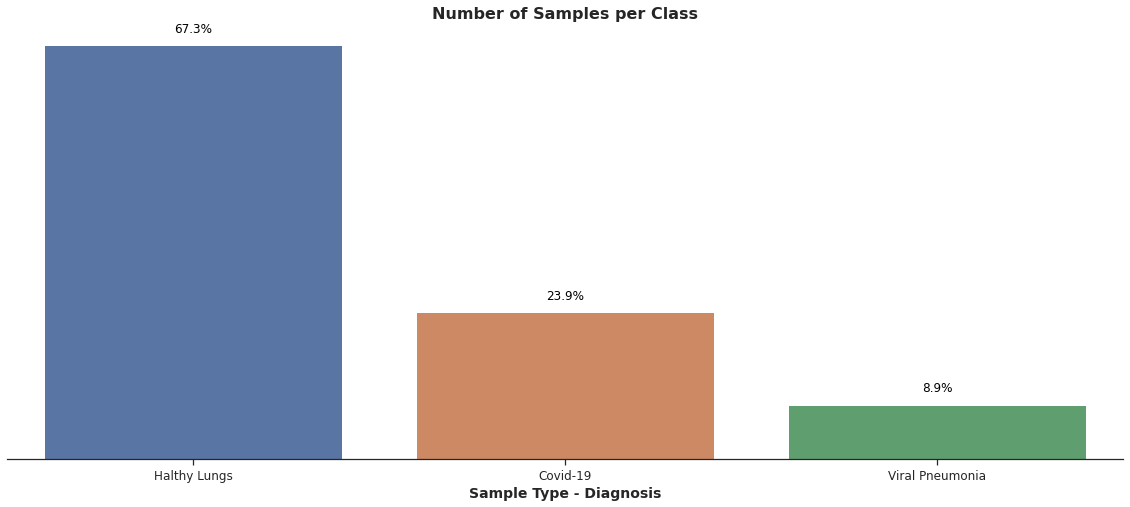

In [87]:
#Samples per class
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold')
#Plot numbers
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

In [88]:
healthy_lungs=(10192/15153)*100
covid_19=(3616/15153)*100
viral_pneumonia=(1345/15153)*100

print(healthy_lungs)
print(covid_19)
print(viral_pneumonia)

67.26060846037089
23.86326140038276
8.876130139246353


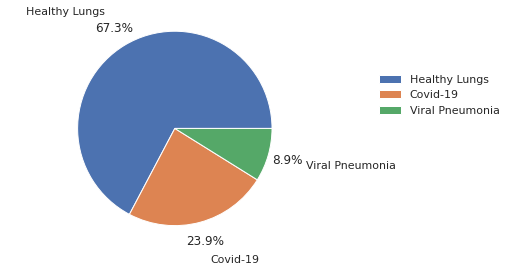

In [89]:
fig,ax=plt.subplots()
labels = ['Healthy Lungs', 
         'Covid-19',
         'Viral Pneumonia']
percentages = [67.26,23.86,8.87]
ax.pie(percentages, labels=labels,  autopct='%1.1f%%',shadow=False, startangle=0,   pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
#ax.set_title("Percentage of Classes")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.savefig('percentage-pie chart.png')

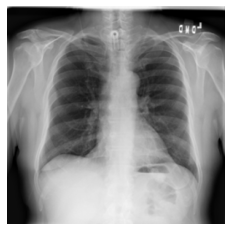

<Figure size 432x288 with 0 Axes>

In [93]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = covidData['path'][pic_id]
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off');
plt.show()   
plt.savefig("sample.jpg")

In [91]:
print('Shape of the image : {}'.format(image.shape))
print('Image Hight {}'.format(image.shape[0]))
print('Image Width {}'.format(image.shape[1]))
print('Dimension of Image {}'.format(image.ndim))
print('Image size {}'.format(image.size))
print('Image Data Type {}'.format(image.dtype))
print('Maximum RGB value in this image {}'.format(image.max()))
print('Minimum RGB value in this image {}'.format(image.min()))

Shape of the image : (299, 299, 3)
Image Hight 299
Image Width 299
Dimension of Image 3
Image size 268203
Image Data Type uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0


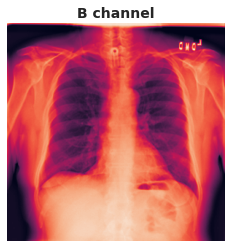

<Figure size 432x288 with 0 Axes>

In [94]:
plt.title('B channel',fontsize = 14,weight = 'bold')
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()
plt.savefig("Blue channel of sample.jpg")

In [97]:
covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

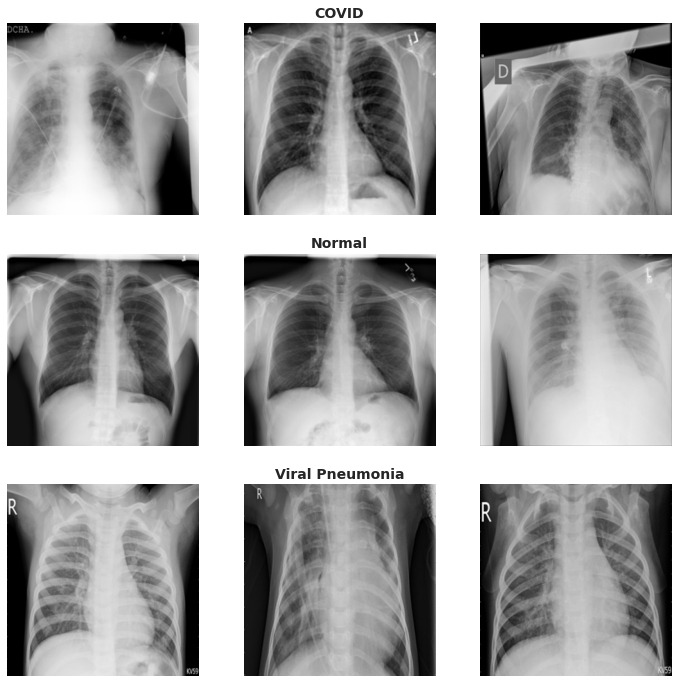

In [98]:
#Image Sampling
n_samples = 3

fig, m_axs = plt.subplots(3, n_samples, figsize = (4*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs,covidData.sort_values(['diagnosis']).groupby('diagnosis')):
    n_axs[1].set_title(type_name,fontsize = 14,weight = 'bold')
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')
plt.savefig('sample images of classes.png')

In [100]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0,samples):
    mean_val.append(covidData['image'][i].mean())
    std_dev_val.append(np.std(covidData['image'][i]))
    max_val.append(covidData['image'][i].max())
    min_val.append(covidData['image'][i].min())

imageEDA = covidData.loc[:,['image', 'Class','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples

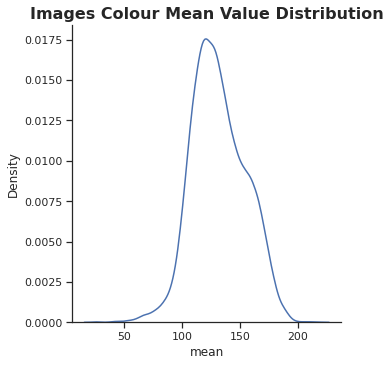

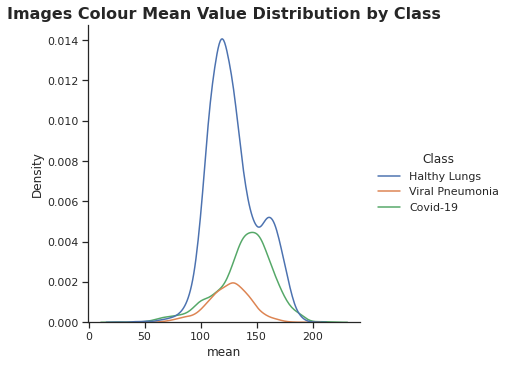

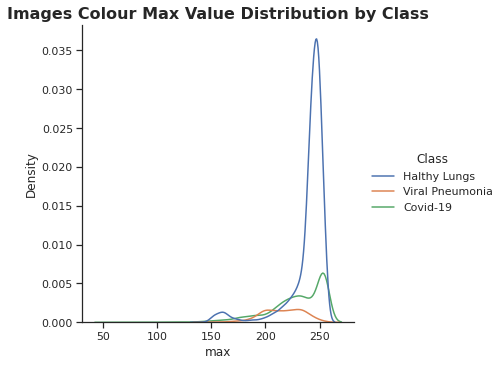

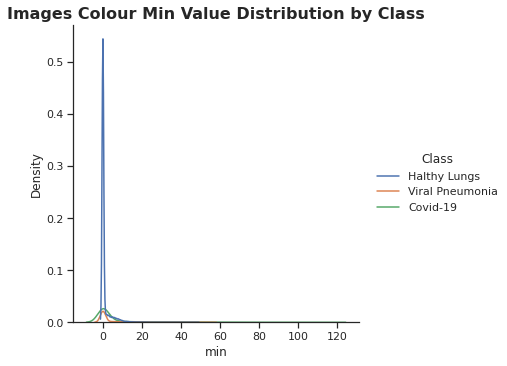

In [101]:
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde");
plt.title('Images Colour Mean Value Distribution', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'Class');
plt.title('Images Colour Mean Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'Class');
plt.title('Images Colour Max Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'Class');
plt.title('Images Colour Min Value Distribution by Class', fontsize = 16,weight = 'bold');

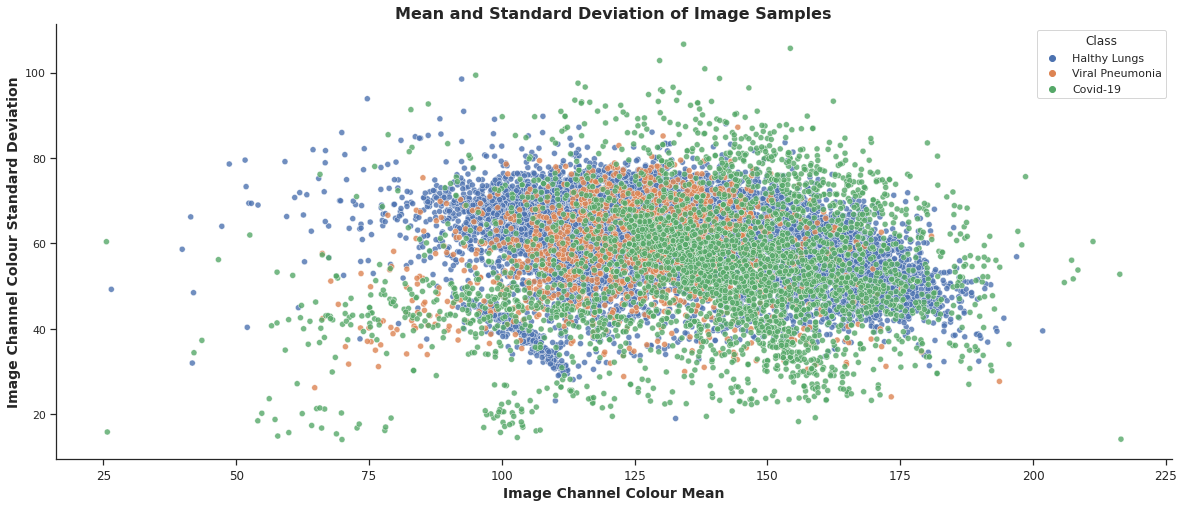

In [109]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=imageEDA, x="mean", y=imageEDA['stedev'], hue = 'Class',alpha=0.8);
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold');
plt.savefig('Mean and Standard Deviation of Image Samples.jpg')

<Figure size 1440x576 with 0 Axes>

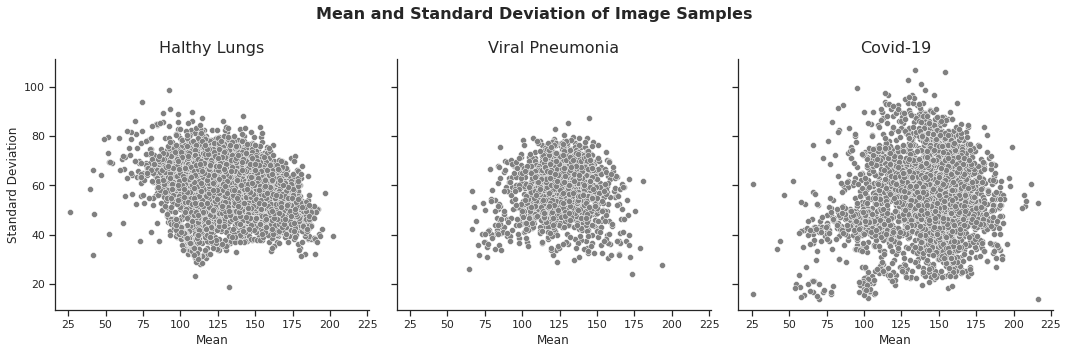

In [111]:
plt.figure(figsize=(20,8));
g = sns.FacetGrid(imageEDA, col="Class",height=5);
g.map_dataframe(sns.scatterplot, x='mean', y='stedev',color="gray");
g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 16)
g.fig.subplots_adjust(top=.7)
g.fig.suptitle('Mean and Standard Deviation of Image Samples',fontsize=16, weight = 'bold')
axes = g.axes.flatten()
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('Mean')
g.fig.tight_layout()
plt.savefig('Mean and Standard Deviation of Image Samples different classes.jpg')

# CNN MODEL

In [2]:
DIR_PATH = '../input/covid19data/'
CLASSES = ['Normal', 'Viral Pneumonia', 'COVID']

In [3]:
all_data = []
for dirname, _, filenames in os.walk(DIR_PATH):
    for file in filenames:
        if 'png' in file:
            image = cv2.imread(os.path.join(dirname, file))
            image = cv2.resize(image, (100,100)) / 255.0
            label = CLASSES.index(os.path.split(dirname)[-1])
            all_data.append([image, label])

In [4]:
X = []
y = []
for img, lbl in all_data:
    X.append(img)
    y.append(lbl)
X = np.array(X)
y = np.array(y)

In [5]:
X.shape

(15153, 100, 100, 3)

In [6]:
y.shape

(15153,)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [8]:
import tensorflow as tf
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [5]:
#with tpu_strategy.scope():
model8=Sequential([
    Conv2D(64,(3,3),activation='relu',input_shape=(100,100,3)),
    BatchNormalization(),

    Conv2D(64,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64,(3,3),activation='relu'),
    BatchNormalization(),

    Conv2D(64,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(128,activation='relu'),
    Dense(3,activation='softmax')
    ])
    model8.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    
    #tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [14]:
model8.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 98, 98, 64)        1792      
_________________________________________________________________
batch_normalization_12 (Batc (None, 98, 98, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 46, 46, 64)       

In [15]:
callbacks=[ReduceLROnPlateau(monitor='loss',facotr=0.5,patience=5,min_lr=0.001)]
history = model8.fit(X_train, y_train, epochs=250, batch_size=32,validation_data=(X_val, y_val),steps_per_epoch=len(X_train) // 32, validation_steps=len(X_val) // 32,callbacks=callbacks)

Epoch 1/250
321/321 [==============================] - 21s 34ms/step - loss: 0.7786 - accuracy: 0.6415 - val_loss: 1.2924 - val_accuracy: 0.2427
Epoch 2/250
321/321 [==============================] - 7s 21ms/step - loss: 0.5604 - accuracy: 0.7495 - val_loss: 0.8953 - val_accuracy: 0.4425
Epoch 3/250
321/321 [==============================] - 7s 21ms/step - loss: 0.5011 - accuracy: 0.7855 - val_loss: 1.0340 - val_accuracy: 0.6724
Epoch 4/250
321/321 [==============================] - 7s 20ms/step - loss: 0.4539 - accuracy: 0.8045 - val_loss: 0.4688 - val_accuracy: 0.8108
Epoch 5/250
321/321 [==============================] - 7s 21ms/step - loss: 0.3886 - accuracy: 0.8397 - val_loss: 1.2293 - val_accuracy: 0.4068
Epoch 6/250
321/321 [==============================] - 7s 21ms/step - loss: 0.3554 - accuracy: 0.8576 - val_loss: 0.5018 - val_accuracy: 0.8231
Epoch 7/250
321/321 [==============================] - 7s 21ms/step - loss: 0.3535 - accuracy: 0.8533 - val_loss: 0.4969 - val_accuracy

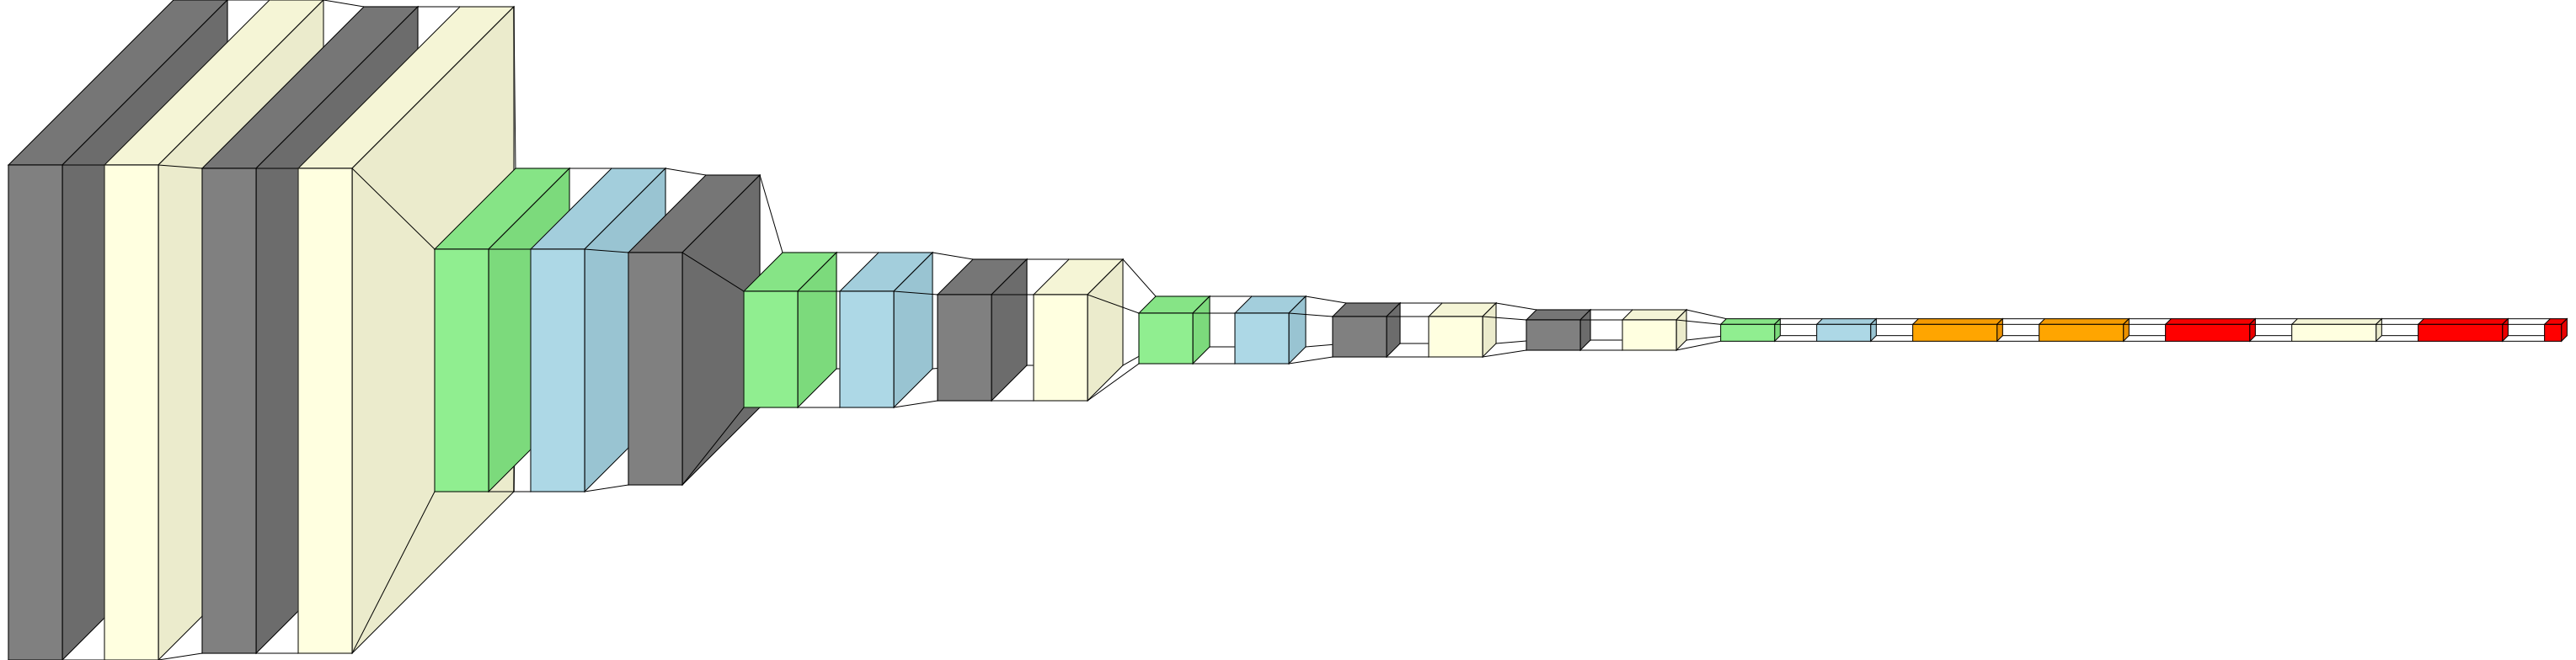

In [19]:
import visualkeras
import collections

color_map = collections.defaultdict(dict)
color_map[Conv2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'lightblue'
color_map[BatchNormalization]['fill'] = 'lightyellow' 
color_map[MaxPooling2D]['fill'] = 'lightgreen'
color_map[Dense]['fill'] = 'red'
color_map[Flatten]['fill'] = 'orange'

visualkeras.layered_view(model8, spacing=50,color_map=color_map,scale_xy=6, scale_z=1, max_z=100)

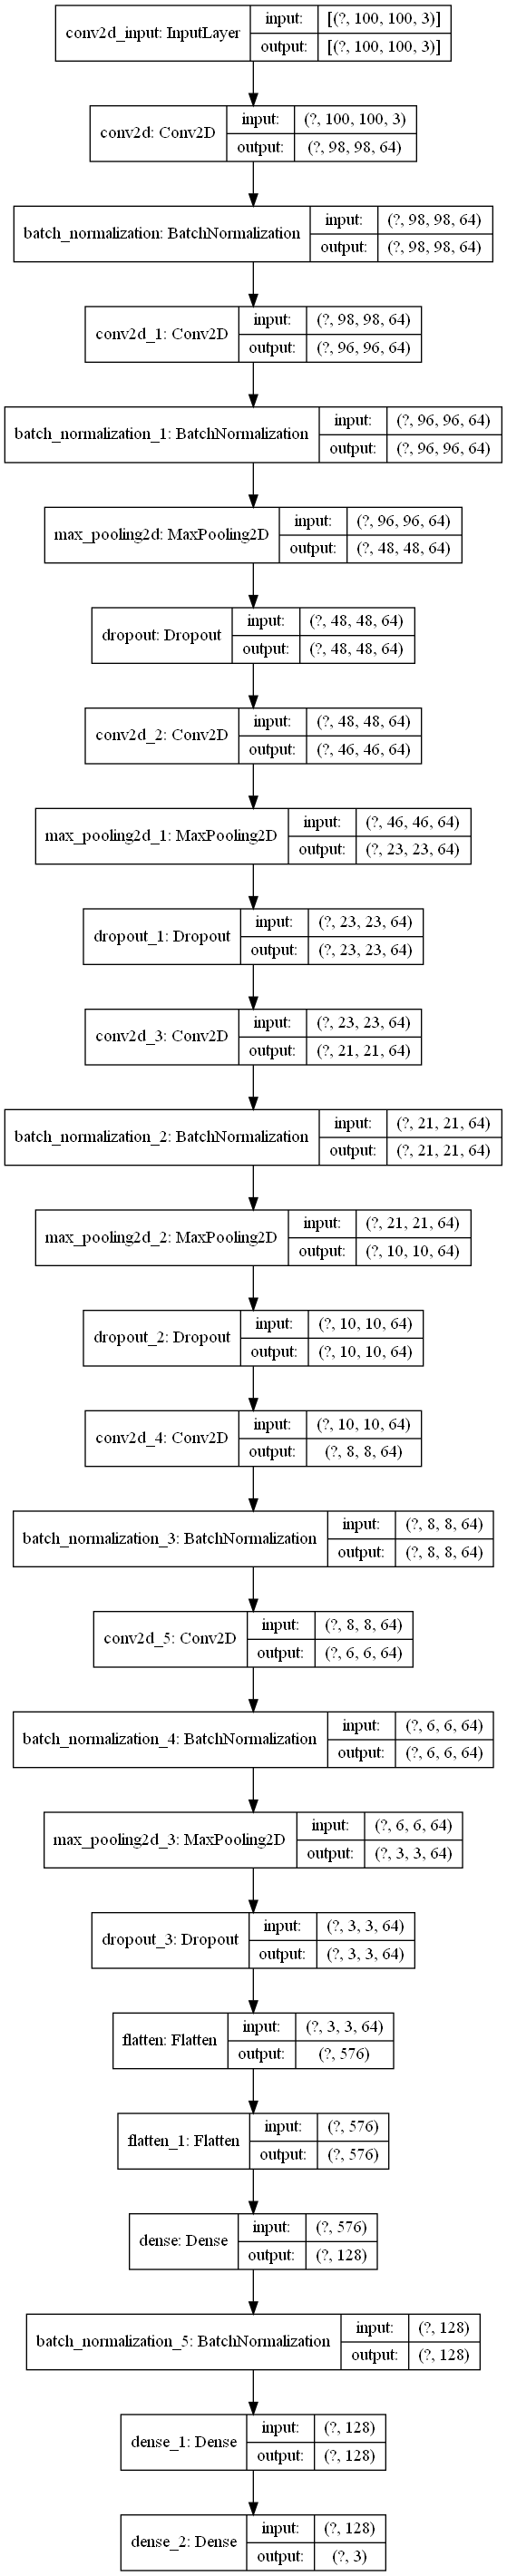

In [7]:
from keras.utils import plot_model
plot_model(model8,show_shapes=True,show_layer_names=True)

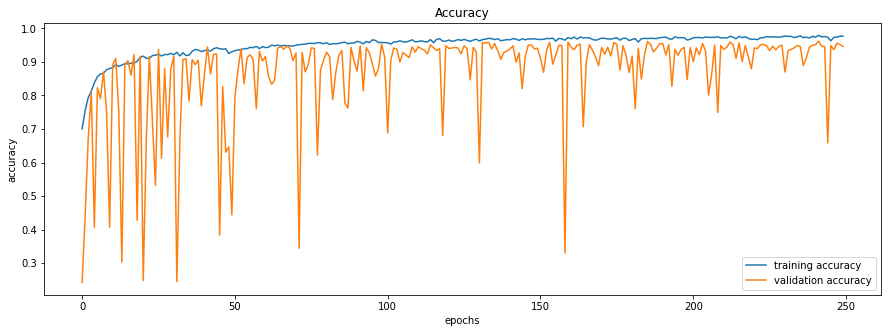

In [16]:
# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(2, 2,
#                        width_ratios=[4,0],
#                        height_ratios=[2,2]
#                        )
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
#grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
#fig.add_subplot(gs[0])
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('accuracy.jpg')

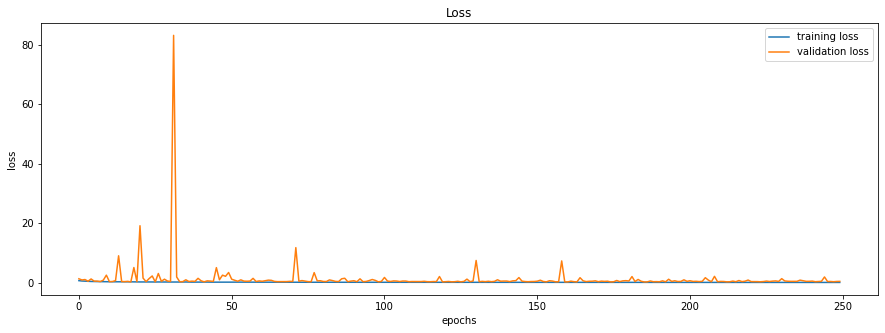

In [17]:
#fig.add_subplot(gs[2])
fig = plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss.jpg')

In [18]:
model8.save("model8.h5")

In [21]:
y_test

array([2, 2, 0, ..., 2, 0, 0])

In [24]:
p = model8.predict(X_test)

In [27]:
print(p)

[[3.25098123e-14 7.34033500e-15 1.00000000e+00]
 [1.34062006e-08 4.85478924e-15 1.00000000e+00]
 [9.38831642e-02 1.01058455e-02 8.96010995e-01]
 ...
 [1.50966756e-15 4.65230261e-19 1.00000000e+00]
 [9.99286711e-01 1.80962601e-07 7.13057467e-04]
 [9.99718249e-01 1.89222393e-09 2.81735411e-04]]


In [28]:
classes = np.argmax(p, axis = 1)
classes

array([2, 2, 2, ..., 2, 0, 0])

In [52]:
model8.evaluate(X_test,y_test, verbose=2)

95/95 - 3s - loss: 0.3319 - accuracy: 0.9396


[0.33193251490592957, 0.9396238327026367]

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
print(classification_report(y_test,classes,target_names=['Normal', 'Viral Pneumonia', 'COVID']))

                 precision    recall  f1-score   support

         Normal       0.99      0.93      0.96      2039
Viral Pneumonia       0.92      0.95      0.93       269
          COVID       0.83      0.97      0.90       723

       accuracy                           0.94      3031
      macro avg       0.91      0.95      0.93      3031
   weighted avg       0.95      0.94      0.94      3031



             Class  Precision  Recall  F-1 Score
0           Normal       0.99    0.93       0.96
1  Viral Pneumonia       0.92    0.95       0.93
2            Covid       0.83    0.97       0.90


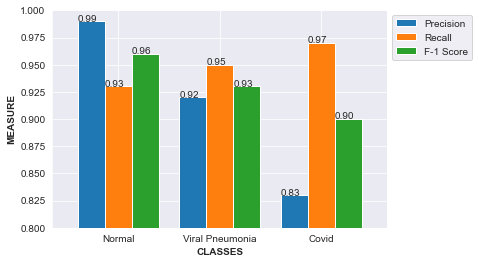

In [18]:
from decimal import Decimal
df1 = pd.DataFrame({
    'Class': ['Normal','Viral Pneumonia','Covid'],
    'Precision': [0.99,0.92,0.83],
    'Recall': [0.93,0.95,0.97],
    'F-1 Score':[0.96,0.93,0.90]
})

print(df1)
df1.head(10)

sns.set_style("darkgrid")
ax=df1.plot(x="Class",y=["Precision","Recall","F-1 Score"],kind="bar",width=0.8,figsize=(6,4))
for p in ax.patches:
    ax.annotate('{:.2f}'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()))
plt.xlabel("CLASSES",fontweight='bold')
plt.ylabel("MEASURE",fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0.8,1)
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
plt.show()
# plt.savefig("performance comparison of the classes.png")

[[1891   18  130]
 [   4  255   10]
 [  17    4  702]]


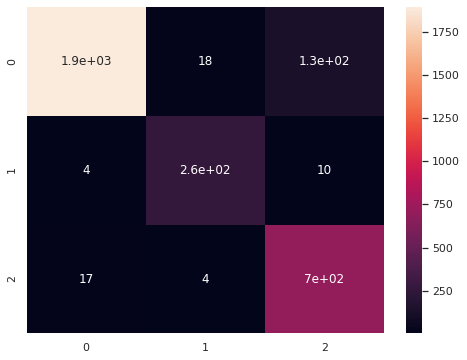

In [48]:
matrix = confusion_matrix(y_test,classes)
print(matrix)
plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True)
plt.savefig("confusion matrix")

In [ ]:
model4=keras.models.load_model("model4.h5")
#model4="./model4.h5"

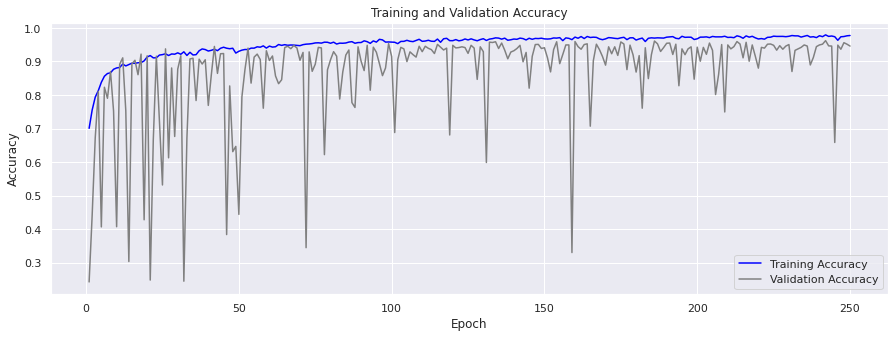

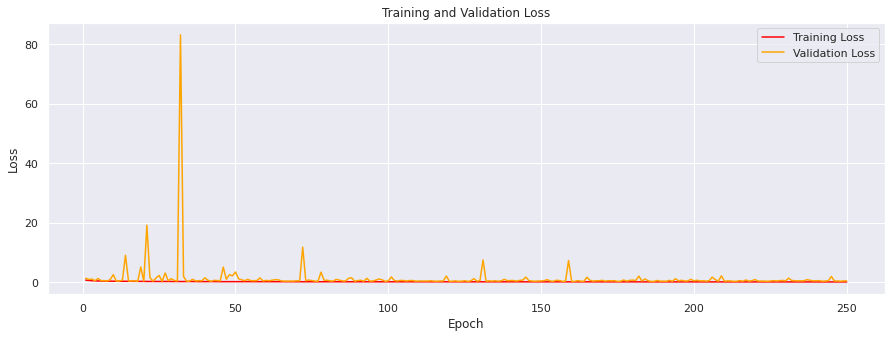

<Figure size 432x288 with 0 Axes>

In [19]:
#plotting training values
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.figure(figsize=(15,5))
plt.plot(epochs, acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='gray', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('accuracy_sns.png')



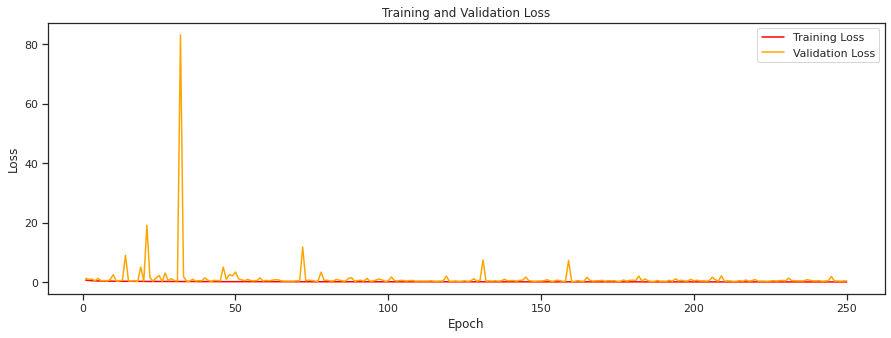

<Figure size 432x288 with 0 Axes>

In [99]:
plt.figure(figsize=(15,5))
#loss plot
plt.plot(epochs, loss, color='red', label='Training Loss')
plt.plot(epochs, val_loss, color='orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss_sns.png')

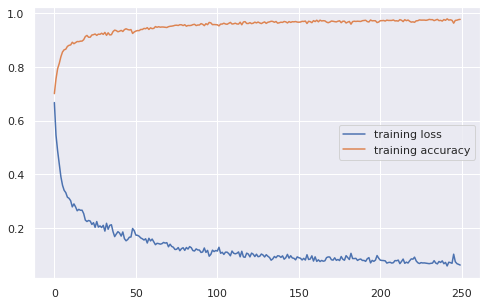

In [20]:
#train data accuracy and loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.savefig('training_accuracy_loss_sns.png')

In [59]:
from sklearn.metrics import roc_auc_score
# calculate AUC
#auc = roc_auc_score(y_test,p)
auc=roc_auc_score(y_test, p, multi_class="ovr",average='macro')
print('AUC: %.3f' % auc)

AUC: 0.992


In [83]:
probs = model8.predict_proba(X_test)
# probs = probs[:, 1]
# probs
probs_classes = np.argmax(probs, axis = 1)
probs_classes

array([2, 2, 2, ..., 2, 0, 0])

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# predict probabilities
probs = model8.predict_proba(X_test)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
probs_classes = np.argmax(probs, axis = 1)
probs_classes
# calculate scores
auc = roc_auc_score(y_test, probs_classes, multi_class="ovr",average='macro')
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, probs_classes, multi_class="ovr",average='macro')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='CNN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

lr_probs = model8.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
# yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, classes), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
# no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()